In [4]:
import numpy as np
import pylab # Plotting
import copy
from qiskit import BasicAer # Q.C simulator
from qiskit.aqua import aqua_globals, QuantumInstance # Tools from aqua required to run experiment
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE # Gives exact energies of classical caluculation to compare with
from qiskit.aqua.components.optimizers import SLSQP # Classical optimiser to update ansatz
from qiskit.chemistry.components.initial_states import HartreeFock # Initial guess
from qiskit.chemistry.components.variational_forms import UCCSD # Converts initial HartreeFock guess into VQE ansatz
from qiskit.chemistry.drivers import PySCFDriver # Set up molecule
from qiskit.chemistry.core import Hamiltonian, QubitMappingType # Helps do mapping

In [5]:
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}' # Initiates molecule, varying distances in {z direction}
distances = np.arange(0.5, 4.25, 0.25) # Distances we want to calculate ground state energy for in amstrongs
vqe_energies = [] # Ground state energies calculated by VQE
hf_energies = [] # Energies from initial HartreeFock guess
exact_energies = [] # Calculated by classical solver

In [13]:
for i,d in enumerate(distances):
    print('step',i)
    driver = PySCFDriver(molecule.format(d/2), basis='sto3g') # Basis is how driver represents orbitals
    qmolecule = driver.run() # Sets up quantum molecule

    operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY, # Sets up hamiltonian, inputing mapping to Q.C
                            two_qubit_reduction=True, # Speeds up calculations
                            freeze_core=True, # Freezes components that don't contribute to bonding, speeding up calculation
                            orbital_reduction=[-3,-2]) # Reduces orbitals that don't contribute

    
    qubit_op, aux_ops = operator.run(qmolecule) # Runs classical calculation
    exact_result = NumPyMinimumEigensolver(qubit_op, aux_operators=aux_ops).run()
    exact_result = operator.process_algorithm_result(exact_result)

    #VQE
    optimiser = SLSQP(maxiter=1000) # Try 1000 times before converging
    initial_state = HartreeFock(operator.molecule_info['num_orbitals'], 
                                operator.molecule_info['num_particles'], 
                                qubit_mapping=operator._qubit_mapping, 
                                two_qubit_reduction=operator._two_qubit_reduction)
    var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'], 
                    num_particles=operator.molecule_info['num_particles'], 
                    initial_state=initial_state, qubit_mapping=operator._qubit_mapping, 
                    two_qubit_reduction=operator._two_qubit_reduction)
    algo = VQE(qubit_op, var_form, optimiser, aux_operators=aux_ops)

    vqe_result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
    vqe_result = operator.process_algorithm_result(vqe_result)

    exact_energies.append(exact_result.energy)
    vqe_energies.append(vqe_result.energy)
    hf_energies.append(vqe_result.hartree_fock_energy)

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14


Text(0.5, 1.0, 'LiH Ground State Energy')

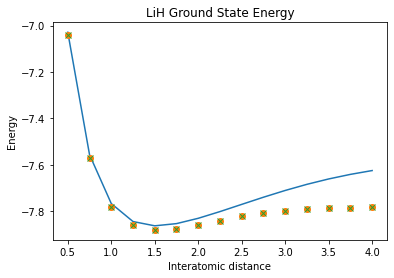

In [17]:
pylab.plot(distances, hf_energies,label='Hartree-Fock')
pylab.plot(distances, vqe_energies, 'o', label='VQE')
pylab.plot(distances, exact_energies, 'x', label='Exact')

pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('LiH Ground State Energy')